In [27]:
# ==============================================
# Portfolio Optimization Project
# Objective: Build 2 portfolios - equal weighted & optimized via Monte-Carlo simulation
# Using: Python (Pandas, Numpy, yfinance, Matplotlib)
# ==============================================

# Step 0: Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Ensures plots show in notebook
%matplotlib inline

# ==============================================
# Step 1: Download historical stock data (2 years)
# ==============================================
# Choose 4 popular stocks
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']

# Download Adjusted Close prices from Yahoo Finance
data = yf.download(tickers, start='2023-01-01', end='2025-01-01')

# Select only the 'Close' prices and flatten the column index
if isinstance(data, pd.DataFrame):
    data = data['Close']
    # Convert the index to datetime
    data.index = pd.to_datetime(data.index)
else:
    print("Error: Downloaded data is not a DataFrame.")


# Display the first 5 rows
print(" Stock Price Data:")
print(data.head())

# ==============================================

/tmp/ipython-input-2583577424.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2023-01-01', end='2025-01-01')
[*********************100%***********************]  4 of 4 completed

 Stock Price Data:
Ticker            AAPL       AMZN      GOOGL        MSFT
Date                                                    
2023-01-03  123.330650  85.820000  88.509544  234.423553
2023-01-04  124.602707  85.139999  87.476669  224.169144
2023-01-05  123.281326  83.120003  85.609543  217.525253
2023-01-06  127.817352  86.080002  86.741714  220.088882
2023-01-09  128.339996  87.360001  87.417076  222.231766


In [33]:
# ==============================================
# Step 2: Calculate Daily Returns
# ==============================================
# Percentage change gives daily return
returns = data.pct_change().dropna()
print("\nDaily Returns:")
print(returns.head())


Daily Returns:
Ticker          AAPL      AMZN     GOOGL      MSFT
Date                                              
2023-01-04  0.010314 -0.007924 -0.011670 -0.043743
2023-01-05 -0.010605 -0.023726 -0.021344 -0.029638
2023-01-06  0.036794  0.035611  0.013225  0.011785
2023-01-09  0.004089  0.014870  0.007786  0.009736
2023-01-10  0.004456  0.028732  0.004544  0.007617



Equal-Weighted Portfolio Performance:
Expected Annual Return: 40.96%
Portfolio Volatility (Risk): 20.78%


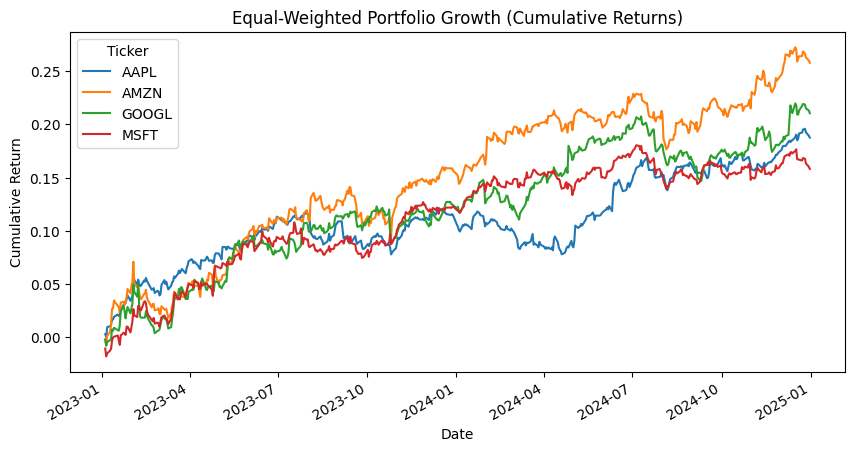

In [32]:
# ==============================================
# Step 3: Equal-Weighted Portfolio
# ==============================================
# Each stock gets 25% allocation
weights = np.array([0.25, 0.25, 0.25, 0.25])

# Expected annual return (average daily return * 252 trading days)
annual_returns = returns.mean() * 252
portfolio_return = np.dot(weights, annual_returns)

# Portfolio risk (volatility) using covariance matrix
cov_matrix = returns.cov() * 252  # annualized
portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
portfolio_volatility = np.sqrt(portfolio_variance)

# Display Equal-Weighted Portfolio metrics
print("\nEqual-Weighted Portfolio Performance:")
print("Expected Annual Return: {:.2f}%".format(portfolio_return * 100))
print("Portfolio Volatility (Risk): {:.2f}%".format(portfolio_volatility * 100))

# Visualize cumulative returns of equal-weighted portfolio
(returns * weights).cumsum().plot(figsize=(10,5))
plt.title("Equal-Weighted Portfolio Growth (Cumulative Returns)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.show()

In [24]:
# ==============================================
# Step 4: Monte-Carlo Simulation for 10,000 Portfolios
# ==============================================
num_portfolios = 10000
results = np.zeros((3, num_portfolios))  # To store Return, Volatility, Sharpe
weights_record = []  # To store weight combinations

for i in range(num_portfolios):
    # Randomly assign weights and normalize to sum = 1
    weights = np.random.random(4)
    weights /= np.sum(weights)
    weights_record.append(weights)

    # Portfolio return
    portfolio_return = np.dot(weights, annual_returns)

    # Portfolio risk (volatility)
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    portfolio_volatility = np.sqrt(portfolio_variance)

    # Sharpe Ratio (risk-free rate = 0)
    sharpe_ratio = portfolio_return / portfolio_volatility

    # Store results
    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = sharpe_ratio

# Convert results to DataFrame for easy analysis
results_df = pd.DataFrame(results.T, columns=["Returns", "Volatility", "Sharpe Ratio"])


In [31]:
# ==============================================
# Step 5: Identify Optimal Portfolio (Max Sharpe Ratio)
# ==============================================
max_sharpe = results_df.iloc[results_df['Sharpe Ratio'].idxmax()]
max_sharpe_weights = weights_record[results_df['Sharpe Ratio'].idxmax()]

print("\nOptimal Portfolio (Max Sharpe Ratio):")
print(max_sharpe)
print("\nWeights for each stock in optimal portfolio:")
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {max_sharpe_weights[i]*100:.2f}%")


Optimal Portfolio (Max Sharpe Ratio):
Returns         0.424782
Volatility      0.203121
Sharpe Ratio    2.091277
Name: 1878, dtype: float64

Weights for each stock in optimal portfolio:
AAPL: 56.04%
MSFT: 29.38%
GOOGL: 13.59%
AMZN: 0.98%


/tmp/ipython-input-1984448754.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(max_sharpe[1], max_sharpe[0], color='red', s=100, label="Optimal Portfolio")


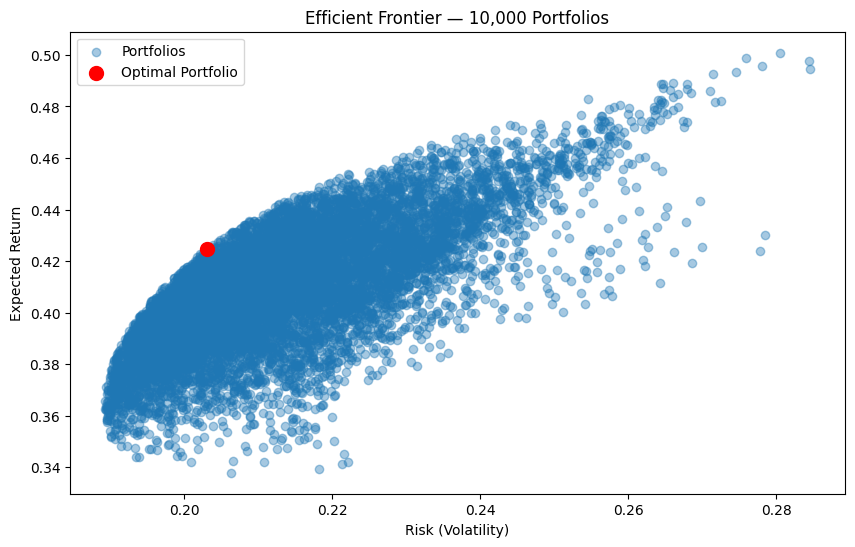

In [26]:
# ==============================================
# Step 6: Plot Efficient Frontier
# ==============================================
plt.figure(figsize=(10,6))
plt.scatter(results_df['Volatility'], results_df['Returns'], alpha=0.4, label="Portfolios")
plt.scatter(max_sharpe[1], max_sharpe[0], color='red', s=100, label="Optimal Portfolio")
plt.title("Efficient Frontier — 10,000 Portfolios")
plt.xlabel("Risk (Volatility)")
plt.ylabel("Expected Return")
plt.legend()
plt.show()